# Results of the OptoSim super-resolution project

### Setup

In [4]:
notebook_name = 'Results'

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
import sys
import json
from sklearn.metrics import mean_squared_error

# import scipy stats
from scipy import stats

import optosim 

from optosim.settings import DATA_DIR, MODEL_DIR

from optosim.simulation.event_reader import EventReader, show_data

from optosim.super_resolution.model import SuperResolutionModel
from optosim.super_resolution.model import create_datasets

import optosim.super_resolution.model_utils as model_utils

from optosim.model_train import read_events, get_model_parameters

from optosim.super_resolution.model_utils import (
    reshape_data,
    weighted_average_estimator,
    downsample_heatmaps_to_dimensions,
    mse,
    r_squared,
)


from optosim.super_resolution.model import SuperResolutionModel, create_datasets




In [6]:
print("DATA_DIR: ", DATA_DIR)
print("MODEL_DIR: ", MODEL_DIR)

DATA_DIR:  /data/xenon/optosim/data/
MODEL_DIR:  /data/xenon/optosim/models/


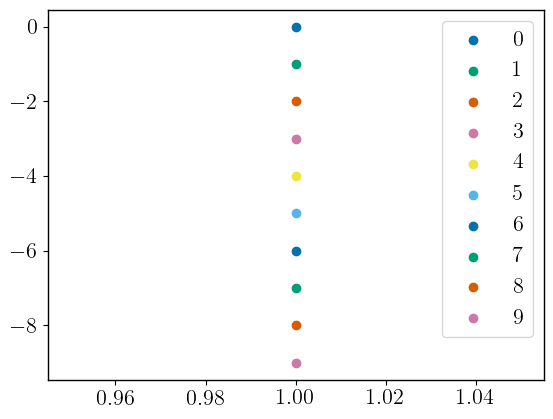

In [7]:
import matplotlib.pyplot as plt

# Set some matplotlib parameters to make it look very nice and LaTex like and professional and really good ready for publication

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "black"

# Plot 10 random lines to test the colors
# Set also the colors to be visually pleasing and colorblind friendly
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams["image.cmap"] = "viridis"

for i in range(10):
    plt.scatter(1, -i, label=i)
plt.legend()
plt.show()

In [8]:
# Make a function to save the figures
# I want to save the figures in a folder called figures
# The prefix of the figure filename needs to be the same as the notebook filename
# The figures folder is located in PROJECT_DIR/notbooks/figures

# Path: Results.ipynb
import os
import matplotlib.pyplot as plt
import optosim
from optosim.settings import PROJECT_DIR

def save_figure(fig, filename, notebook_name=notebook_name):
    """Save a matplotlib figure in the figures folder of the project.
    The prefix of the figure filename needs to be the same as the notebook filename
    The figures folder is located in PROJECT_DIR/notbooks/figures

    Args:
        fig (matplotlib.figure.Figure): Matplotlib figure to save
        filename (str): Filename of the notebook
        prefix (str, optional): Prefix of the figure filename. Defaults to None.
        folder (str, optional): Folder to save the figure in. Defaults to "figures".
    """

    prefix = notebook_name.lower()

    folder = "figures"

    # Save one png and one pdf version of the figure
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.png"), dpi=300, bbox_inches="tight")
    fig.savefig(os.path.join(PROJECT_DIR, "notebook", folder, f"{prefix}-{filename}.pdf"), dpi=300, bbox_inches="tight")

    print(f"Figure saved as {prefix}_{filename}")

### Read the simulation data

In [9]:
show_data(DATA_DIR)

Found 9 subdirectories
Subdirectories:
['mc0006', 'mc0007', 'mc0010', 'mc0011', 'mc0012', 'test_mc0000', 'test_mc0001', 'test_mc0002', 'test_mc0003']
File /data/xenon/optosim/data/test_mc0003/test_mc0003.0000.hdf5 is currently open by another process. Skipping...


,subdir,detector,nevents,nphoton_per_event,scatter,experimental_scatter_model,radius
0,mc0006,XAMS,10000,"[1000, 25000]",NaN,NaN,3.2
1,mc0007,XENONnT,10000,"[1000, 25000]",NaN,NaN,65.0
2,mc0010,XAMS,10000,"[100, 100000]",True,True,3.2
3,mc0011,XAMS,10000,"[100, 100000]",True,False,3.2
4,mc0012,XAMS,10000,"[100, 100000]",False,NaN,3.2


In [47]:
run_id = 'mc0010'
nmax = 5_000

# read data
run_id_dir = os.path.join(DATA_DIR, run_id)
files = glob.glob(run_id_dir + '/*.hd*')

# Invert the order of the files
files = files[::-1]

print(f"Reading data from {run_id_dir}")
print(f"Found {len(files)} files")

for f in files:
    print(f)


Reading data from /data/xenon/optosim/data/mc0010
Found 100 files
/data/xenon/optosim/data/mc0010/mc0010.0098.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0099.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0095.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0097.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0089.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0096.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0088.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0087.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0086.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0085.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0084.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0083.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0094.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0092.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0093.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0091.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0079.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0090.hdf5
/data/xenon/optosim/data/mc0010/mc0010.0069.hdf5
/da

In [48]:

true_pos, fine_top, top = read_events(files, nmax=nmax)
    

number of files:  100
Found 9 subdirectories
Subdirectories:
['mc0006', 'mc0007', 'mc0010', 'mc0011', 'mc0012', 'test_mc0000', 'test_mc0001', 'test_mc0002', 'test_mc0003']
File /data/xenon/optosim/data/test_mc0003/test_mc0003.0000.hdf5 is currently open by another process. Skipping...
processed  0 events


processed  5000 events
We have 5000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


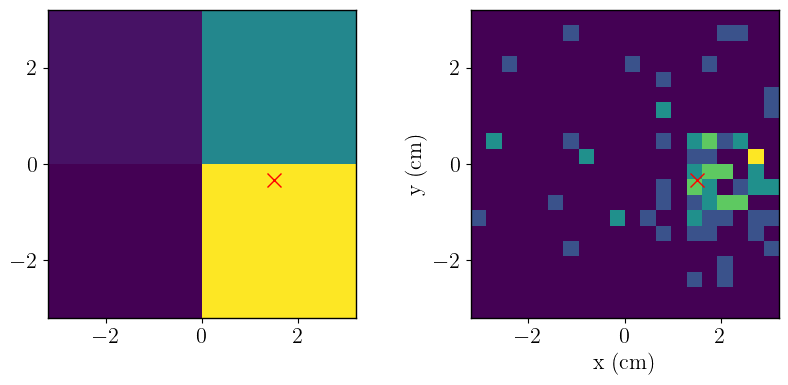

In [71]:
# check if data is ok
num = 0
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.ravel()
r = 3.2

ax[0].imshow(
    top[num], 
    interpolation="nearest", 
    origin="lower", 
    extent=[-r, r, -r, r]
)

ax[1].imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-r, r, -r, r],
)

for i in range(2):
    ax[i].plot(
        true_pos[num][0],
        true_pos[num][1],
        marker="x",
        markersize=10,
        color="red",
        label="true position",
    )

plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

### Make test data

In [72]:
# create train and test sets
y = np.asarray(fine_top)
X = np.asarray(top)
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(X, y, pos, train_fraction=0)


In [73]:
len(X_train), len(X_test)

(0, 5000)

In [74]:
# Let's explore how the data looks like (X_test, y_test and pos_test)
# Let's print some things, shape, columns, values.. 

print("X_test values: ", X_test[0])

print("y_test values: ", y_test[0])

print("pos_test values: ", pos_test[0])

# Print the sum of the values of X_test, y_test

print("X_test sum: ", np.sum(X_test[0]))

print("y_test sum: ", np.sum(y_test[0]))




X_test values:  [[ 5 46]
 [ 7 24]]
y_test values:  [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 2 0 1 0 0 2 1 1 0 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 2 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 2 0 1 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 3 0 2 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 1 0 0 4 0]
 [0 2 0 0 0 0 1 0 0 0 0 0 1 0 2 3 1 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
pos_test values:  [ 1.5078986 -0.3411614]
X_test sum:  82
y_test sum:  82


In [75]:
# Weighted average estimator

wa_pred = weighted_average_estimator(X_test, r=2.5)
wa_mse = mse(pos_test, wa_pred)
wa_r2 = r_squared(pos_test, wa_pred)

### Get the models

In [76]:
# Utils

# Let's make a function to read the models from the pickle files
def read_model(model_name):

    print(f"Reading model {model_name}")
    model_file = os.path.join(MODEL_DIR, run_id, model_name)
    with open(model_file, 'rb') as f:
        model = pickle.load(f)

    return model

# Define a function to get the number of pmts from a filename like model_2x2_mc0006.pkl
def get_pmts_from_filename(filename):
    return int(filename.split("_")[1].split('x')[0])

# Define a function to get the run id from a filename like model_2x2_mc0006.pkl
def get_filename_from_pmts(pmts_per_dim, run_id):
    return f"model_{pmts_per_dim}x{pmts_per_dim}_{run_id}.pkl"


In [77]:


# Define list of models to read
read_all_models = True

if read_all_models:
    # Let's read all the files, nicely sorted, 
    # only the filename without the path,
    # Sort in a way that 2 comes before 10
    models_to_read = [os.path.basename(x) for x in glob.glob(os.path.join(MODEL_DIR, run_id, f"*{run_id}*.pkl"))]
    models_to_read = sorted(models_to_read, key=lambda x: int(get_pmts_from_filename(x)))
else: 
    # Read only these files
    pmts_per_dim_to_load = [2,3,4,5,6,7,8,9,10,11,12]
    models_to_read = [get_filename_from_pmts(pmts_per_dim, run_id) for pmts_per_dim in pmts_per_dim_to_load]


# Let's read all the files
models = {}
for model_name in models_to_read:
    models[model_name] = read_model(model_name)

# Let's make a function to predict the position of the events


Reading model model_2x2_mc0010.pkl
Reading model model_3x3_mc0010.pkl
Reading model model_4x4_mc0010.pkl
Reading model model_5x5_mc0010.pkl
Reading model model_6x6_mc0010.pkl
Reading model model_7x7_mc0010.pkl
Reading model model_8x8_mc0010.pkl
Reading model model_9x9_mc0010.pkl
Reading model model_10x10_mc0010.pkl
Reading model model_11x11_mc0010.pkl
Reading model model_12x12_mc0010.pkl
Reading model model_13x13_mc0010.pkl
Reading model model_14x14_mc0010.pkl
Reading model model_15x15_mc0010.pkl
Reading model model_16x16_mc0010.pkl
Reading model model_17x17_mc0010.pkl
Reading model model_18x18_mc0010.pkl
Reading model model_19x19_mc0010.pkl
Reading model model_20x20_mc0010.pkl


In [56]:
# Make a result dictionary with the results for each model

results = {}

for model_name, model in models.items():
    print(f"Predicting with model {model_name}")

    _pmts = get_pmts_from_filename(model_name)
    res = model.evaluate(X_test, downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts), pos_test)

    results[model_name] = {}
    results[model_name]['PMTs'] = _pmts
    results[model_name]['pred'] = model.predict(X_test)[1]
    results[model_name]['MSE'] = res['MSE']
    results[model_name]['R^2'] = res['R^2']

Predicting with model model_2x2_mc0010.pkl
Predicting with model model_3x3_mc0010.pkl
Predicting with model model_4x4_mc0010.pkl
Predicting with model model_5x5_mc0010.pkl
Predicting with model model_6x6_mc0010.pkl
Predicting with model model_7x7_mc0010.pkl
Predicting with model model_8x8_mc0010.pkl
Predicting with model model_9x9_mc0010.pkl
Predicting with model model_10x10_mc0010.pkl
Predicting with model model_11x11_mc0010.pkl
Predicting with model model_12x12_mc0010.pkl
Predicting with model model_13x13_mc0010.pkl
Predicting with model model_14x14_mc0010.pkl
Predicting with model model_15x15_mc0010.pkl
Predicting with model model_16x16_mc0010.pkl
Predicting with model model_17x17_mc0010.pkl
Predicting with model model_18x18_mc0010.pkl
Predicting with model model_19x19_mc0010.pkl
Predicting with model model_20x20_mc0010.pkl


In [57]:
# I want to print the sum of the values of the predictions for the first element for every model

for model_name, model in models.items():
    print(f"model {model_name}", end=':')

    print("pred sum: ", np.sum(results[model_name]['pred'][0]))

    

model model_2x2_mc0010.pkl:pred sum:  0.15968055535976283
model model_3x3_mc0010.pkl:pred sum:  0.4278226484553742
model model_4x4_mc0010.pkl:pred sum:  1.1468552997493016
model model_5x5_mc0010.pkl:pred sum:  0.5411375715146396
model model_6x6_mc0010.pkl:pred sum:  1.2307801036265649
model model_7x7_mc0010.pkl:pred sum:  0.7995298965633993
model model_8x8_mc0010.pkl:pred sum:  0.7796874570498935
model model_9x9_mc0010.pkl:pred sum:  0.6319627591130635
model model_10x10_mc0010.pkl:pred sum:  1.2936916012791986
model model_11x11_mc0010.pkl:pred sum:  1.4489922760728333
model model_12x12_mc0010.pkl:pred sum:  0.1930662253104488
model model_13x13_mc0010.pkl:pred sum:  0.38921758872694767
model model_14x14_mc0010.pkl:pred sum:  1.425568808719028
model model_15x15_mc0010.pkl:pred sum:  0.3595100276018881
model model_16x16_mc0010.pkl:pred sum:  0.6270721215596804
model model_17x17_mc0010.pkl:pred sum:  1.277260275034582
model model_18x18_mc0010.pkl:pred sum:  0.9810428688743654
model model_1

model: model_2x2_mc0010.pkl          


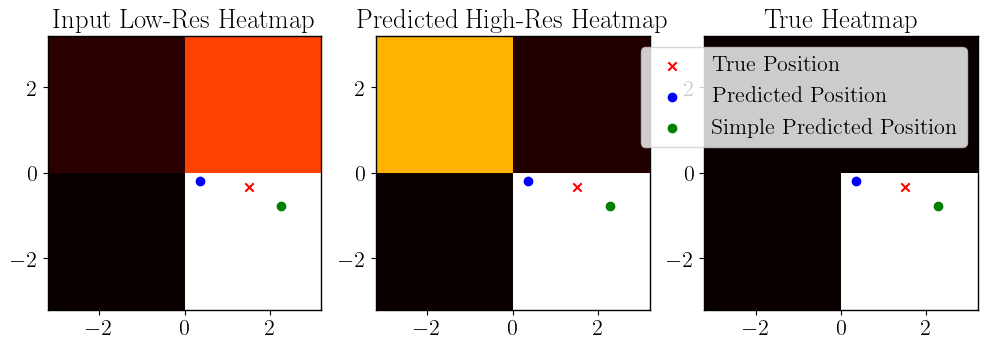

model: model_3x3_mc0010.pkl          


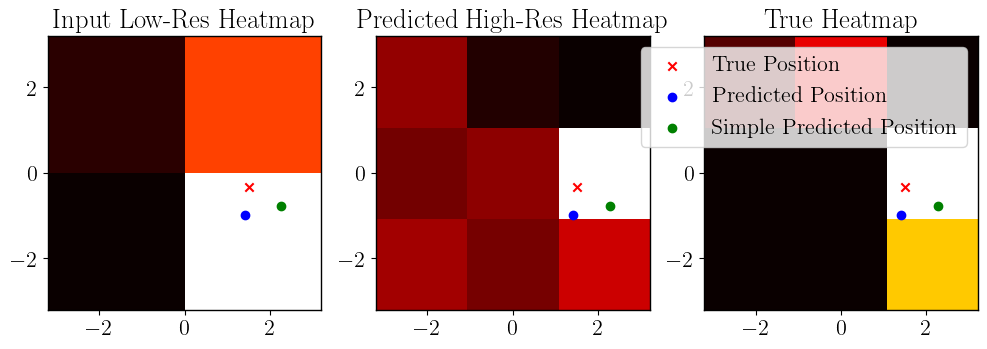

model: model_4x4_mc0010.pkl          


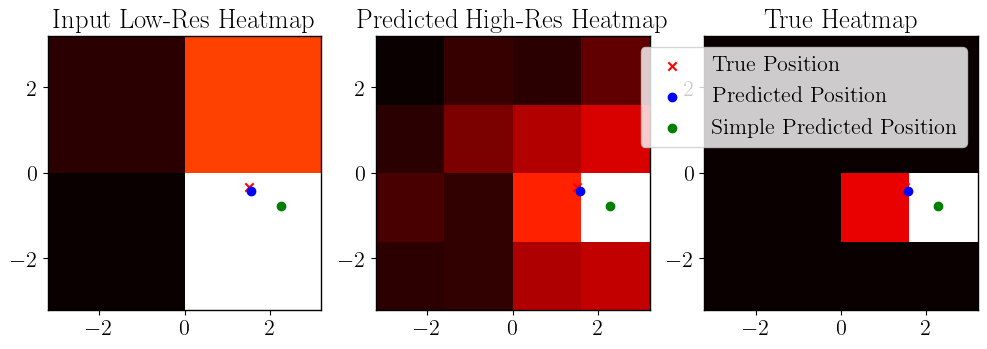

model: model_5x5_mc0010.pkl          


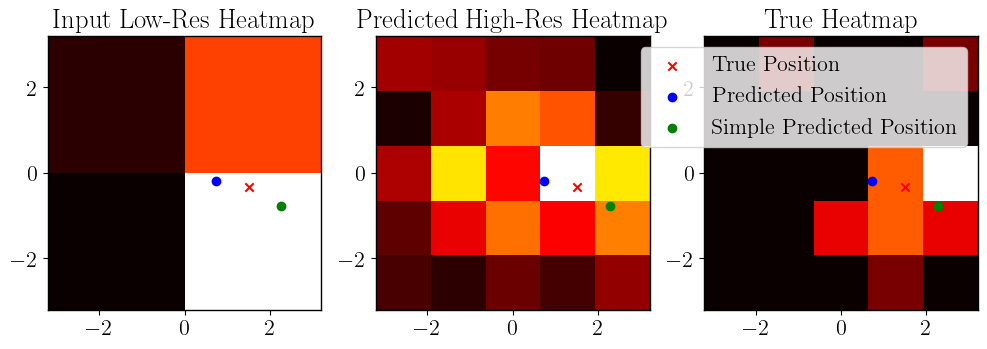

model: model_6x6_mc0010.pkl          


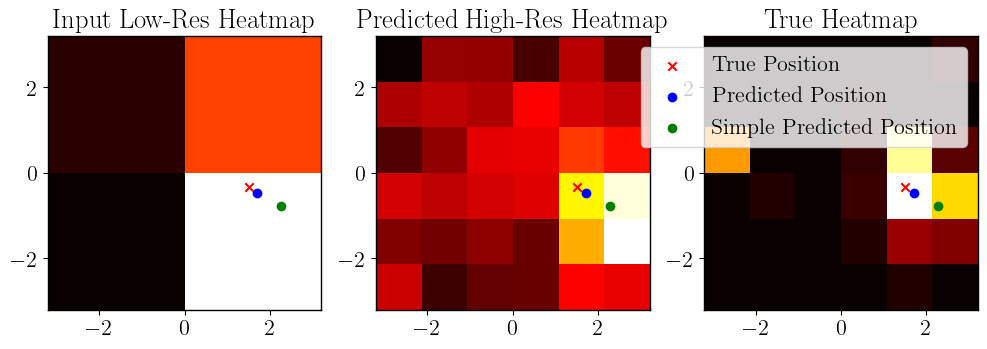

model: model_7x7_mc0010.pkl          


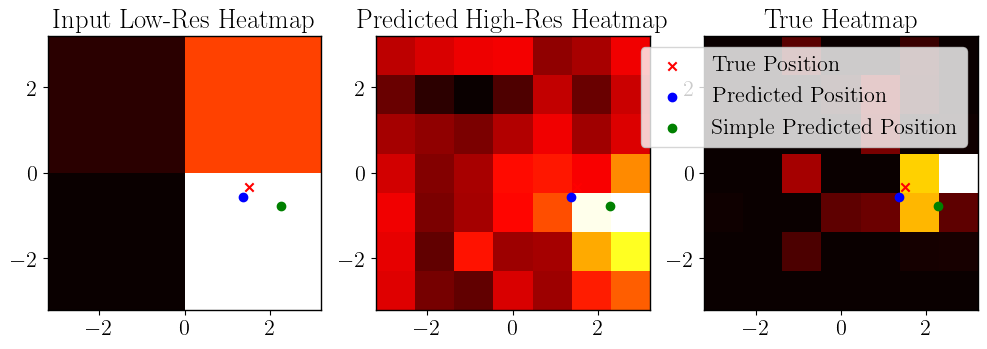

model: model_8x8_mc0010.pkl          


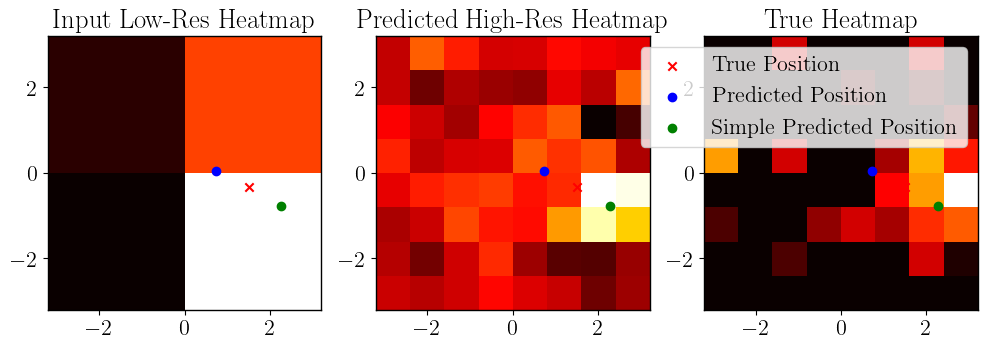

model: model_9x9_mc0010.pkl          


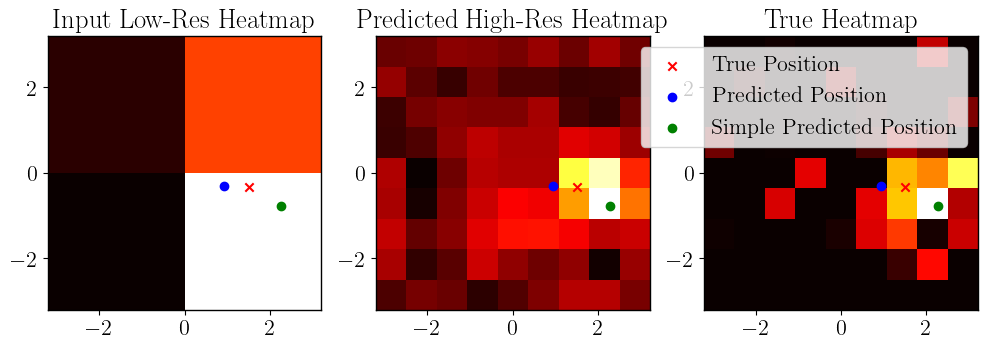

model: model_10x10_mc0010.pkl        


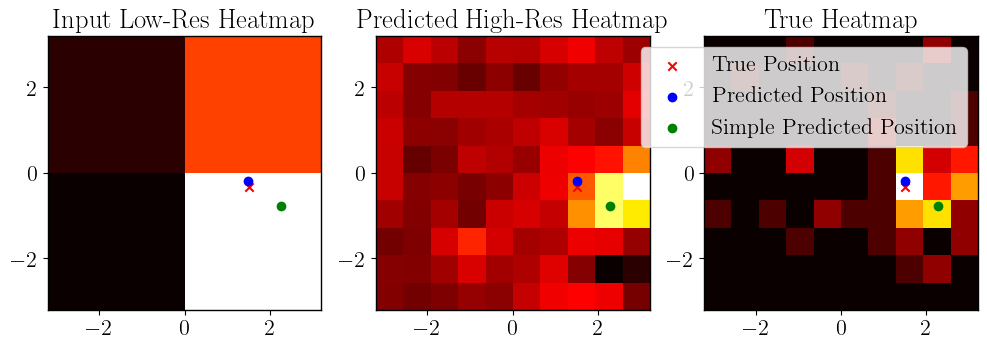

model: model_11x11_mc0010.pkl        


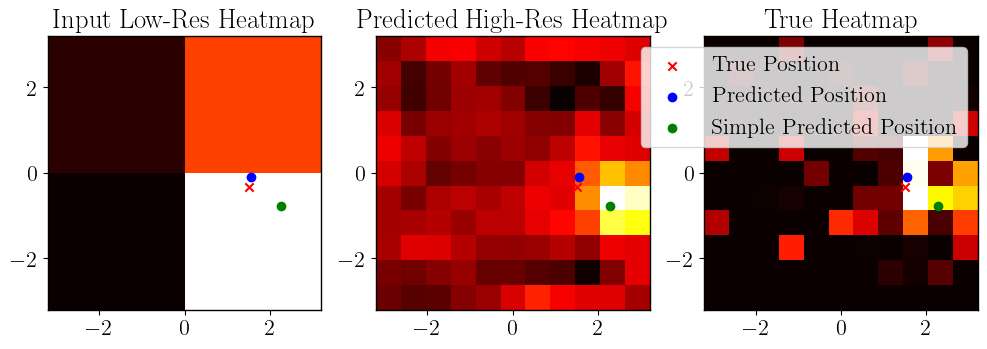

model: model_12x12_mc0010.pkl        


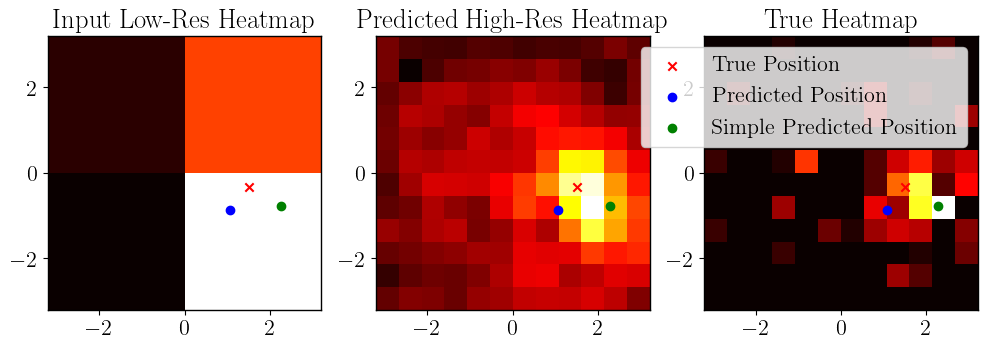

model: model_13x13_mc0010.pkl        


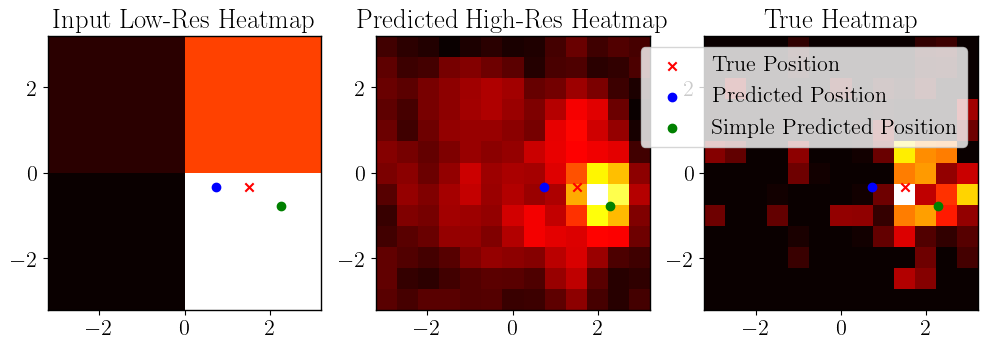

model: model_14x14_mc0010.pkl        


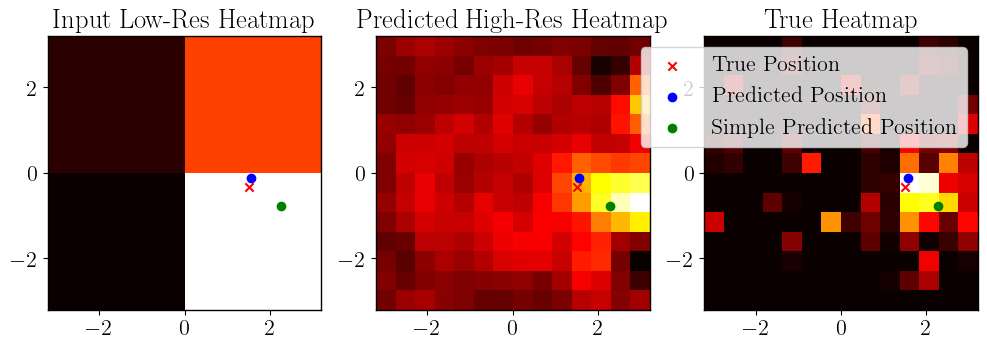

model: model_15x15_mc0010.pkl        


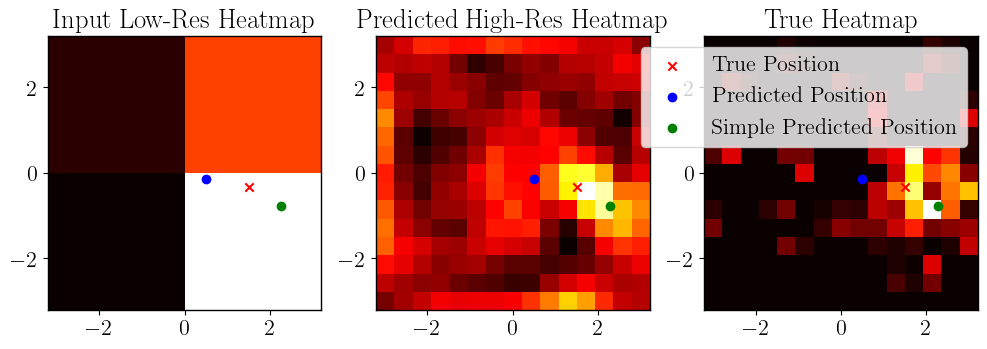

model: model_16x16_mc0010.pkl        


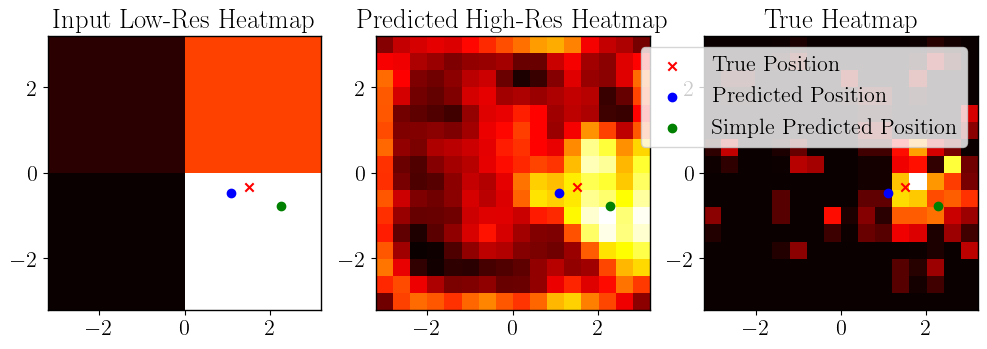

model: model_17x17_mc0010.pkl        


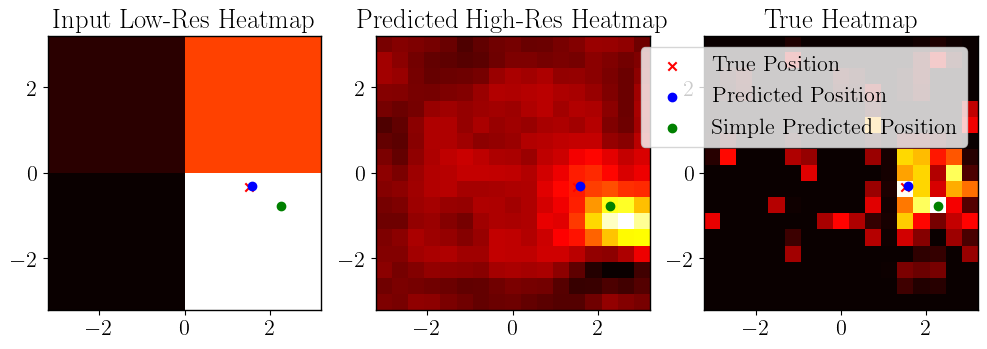

model: model_18x18_mc0010.pkl        


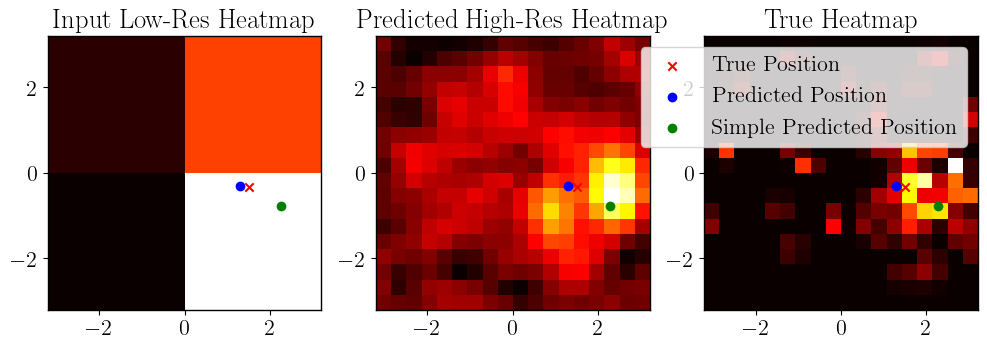

model: model_19x19_mc0010.pkl        


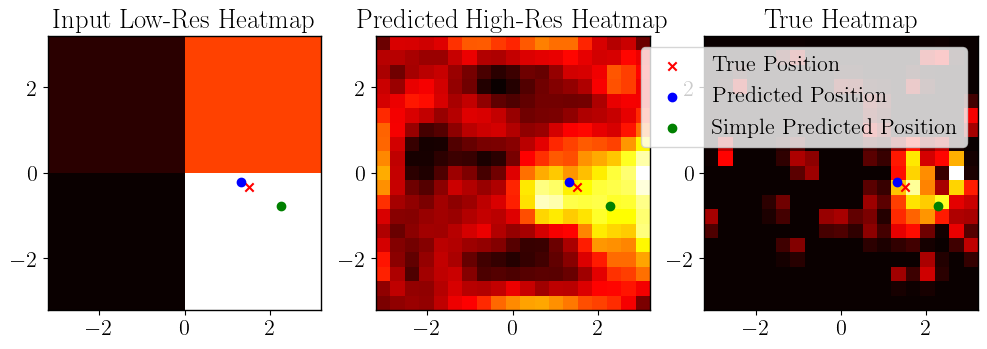

model: model_20x20_mc0010.pkl        


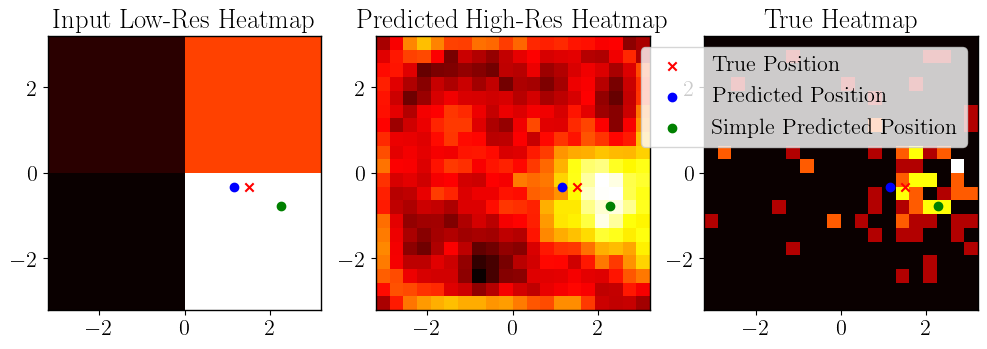

In [58]:
for model_name, model in models.items():

    _pmts = get_pmts_from_filename(model_name)

    print(f"model: {model_name:<30}")

    y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts)

    model.visualize_heatmaps_with_positions(X_test, y_test_downsampled, pos_test, num_plots=1, radius=r)

In [70]:
# plot the training loss for every model

for model_name, model in models.items():
    print(f"model: {model_name:<30}")
    model.plot_training_loss()


model: model_2x2_mc0010.pkl          


AttributeError: 'SuperResolutionModel' object has no attribute 'plot_training_loss'

## Let's make nice plots

- 2d histogram of true x - x vs true y - y :: resolution of best model\\
- 1d histogram of true r - r :: resolution of best model\\
- comparison of resolutions (MSE/R2) for different models\\
- error correlation with position\\

We decide that the best model is 5x5

In [59]:
radius = 3.2

model: model_2x2_mc0010.pkl           --PMTS: 2 -- RSE: 0.5118 -- R^2: 0.8034
model: model_3x3_mc0010.pkl           --PMTS: 3 -- RSE: 0.4377 -- R^2: 0.8319
model: model_4x4_mc0010.pkl           --PMTS: 4 -- RSE: 0.4456 -- R^2: 0.8288
model: model_5x5_mc0010.pkl           --PMTS: 5 -- RSE: 0.4994 -- R^2: 0.8082
model: model_6x6_mc0010.pkl           --PMTS: 6 -- RSE: 0.5010 -- R^2: 0.8075
model: model_7x7_mc0010.pkl           --PMTS: 7 -- RSE: 0.5978 -- R^2: 0.7704
model: model_8x8_mc0010.pkl           --PMTS: 8 -- RSE: 0.4617 -- R^2: 0.8226
model: model_9x9_mc0010.pkl           --PMTS: 9 -- RSE: 0.6475 -- R^2: 0.7513
model: model_10x10_mc0010.pkl         --PMTS: 10 -- RSE: 0.5512 -- R^2: 0.7883
model: model_11x11_mc0010.pkl         --PMTS: 11 -- RSE: 1.2333 -- R^2: 0.5262
model: model_12x12_mc0010.pkl         --PMTS: 12 -- RSE: 0.6533 -- R^2: 0.7491
model: model_13x13_mc0010.pkl         --PMTS: 13 -- RSE: 1.0823 -- R^2: 0.5842
model: model_14x14_mc0010.pkl         --PMTS: 14 -- RSE: 0.5

Figure saved as results_mse_per_model_mc0010


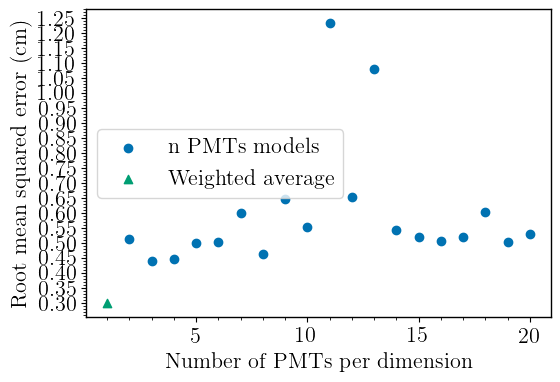

In [60]:
# Do scatter plot with mse only

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, MultipleLocator


# Get the first color of the color cycle from the style
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

for i, model_name in enumerate(models.keys()):

    res = results[model_name]

    # Print for each key of the res dict the key and the value (with 4 digits after the comma), in the same line
    print(f"model: {model_name:<30} --PMTS: {res['PMTs']} -- RSE: {res['MSE']:.4f} -- R^2: {res['R^2']:.4f}")

    if i == 0:
        ax.scatter(res['PMTs'], res['MSE'], label='n PMTs models', color=color)
    else:
        ax.scatter(res['PMTs'], res['MSE'], c=color)


color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

ax.scatter(1, wa_mse, marker='^', color=color, label="Weighted average")

ax.set_ylabel("Root mean squared error (cm)")
ax.set_xlabel("Number of PMTs per dimension")

# Show this plot first, and then again but with log scale

# plt.yscale('log')

# I want the grid to be under the points
ax.set_axisbelow(True)
# ax.grid(True)
# ax.grid(which='minor', alpha=0.2)

# Set y-axis ticks to be non-scientific notation
yaxis = ax.yaxis
yaxis.set_major_formatter(ScalarFormatter())
# yaxis.set_minor_formatter(ScalarFormatter())

# Set y-axis tick frequency to 0.01
yaxis.set_major_locator(MultipleLocator(0.05))
yaxis.set_minor_locator(MultipleLocator(0.01))


# Add ticks on x axis for each PMT number upto 5 then every 5
xaxis = ax.xaxis
xaxis.set_major_locator(MultipleLocator(5))
xaxis.set_minor_locator(MultipleLocator(1))

# Set x-axis ticks to be non-scientific notation
xaxis.set_major_formatter(ScalarFormatter())



# plt.ylim(0.03, 0.25)

plt.legend()

save_figure(fig, f"mse_per_model_{run_id}")
plt.show()



In [61]:
stupid_model_name = f'model_2x2_{run_id}.pkl'
stupid_model = models[stupid_model_name]

model_name = f'model_5x5_{run_id}.pkl'
model = models[model_name]

finest_model_name = f'model_20x20_{run_id}.pkl'
finest_model = models[finest_model_name]

In [62]:
# Best model

_pmts = get_pmts_from_filename(model_name)

print(f"model: {model_name:<30}")

pred_pos = model.predict(X_test)[1]

y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _pmts, _pmts)

# Stupid model

_stupid_pmts = get_pmts_from_filename(stupid_model_name)

print(f"model: {stupid_model_name:<30}")

stupid_pred_pos = stupid_model.predict(X_test)[1]

stupid_y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _stupid_pmts, _stupid_pmts)

# Finest model 

_finest_pmts = get_pmts_from_filename(finest_model_name)

print(f"model: {finest_model_name:<30}")

finest_pred_pos = finest_model.predict(X_test)[1]

finest_y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, _finest_pmts, _finest_pmts)

model: model_5x5_mc0010.pkl          
model: model_2x2_mc0010.pkl          
model: model_20x20_mc0010.pkl        


In [63]:
# How many events do we have in every array

len(X_test), len(y_test), len(pos_test), len(pred_pos)

(5000, 5000, 5000, 5000)

Figure saved as results_dx_dy_best_model_mc0010


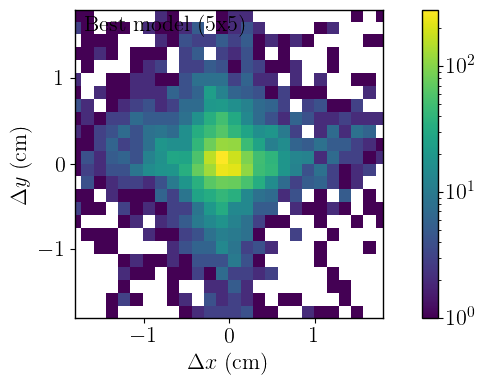

In [64]:
# Make the 2D histogram of (x-x_pred, y-y_pred)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.hist2d(
    pred_pos[:,0] - pos_test[:,0],
    pred_pos[:,1] - pos_test[:,1],
    bins=50,
    norm=LogNorm()
)

# Nice latex labels
plt.xlabel("$\Delta x$ (cm)")
plt.ylabel("$\Delta y$ (cm)")

plt.colorbar()

# Set aspect ratio to 1
ax.set_aspect(1)

# Make it a square
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)

# Add a text with the model name and the number of PMTs in a frame
plt.text(-1.7, 1.55, f"Best model (5x5)", fontsize=16)


save_figure(fig, f"dx_dy_best_model_{run_id}")


plt.show()




Figure saved as results_dx_dy_stupid_model_mc0010


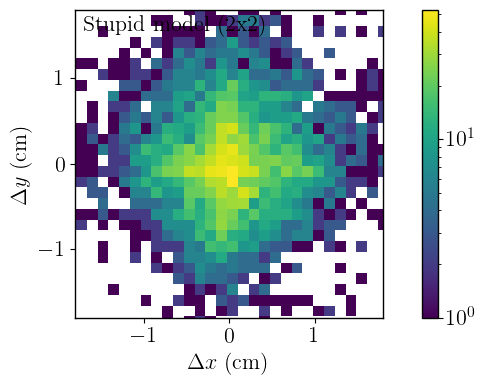

In [65]:
# Make the 2D histogram of (x-x_pred, y-y_pred)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plt.hist2d(
    stupid_pred_pos[:,0] - pos_test[:,0],
    stupid_pred_pos[:,1] - pos_test[:,1],
    bins=50,
    norm=LogNorm()
)

# Nice latex labels
plt.xlabel("$\Delta x$ (cm)")
plt.ylabel("$\Delta y$ (cm)")

plt.colorbar()

# Set aspect ratio to 1
ax.set_aspect(1)

# Make it a square
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)

# Add a text with the model name and the number of PMTs in a frame
plt.text(-1.7, 1.55, f"Stupid model (2x2)", fontsize=16)


save_figure(fig, f"dx_dy_stupid_model_{run_id}")

plt.show()




Figure saved as results_dr_per_model_{run_id}


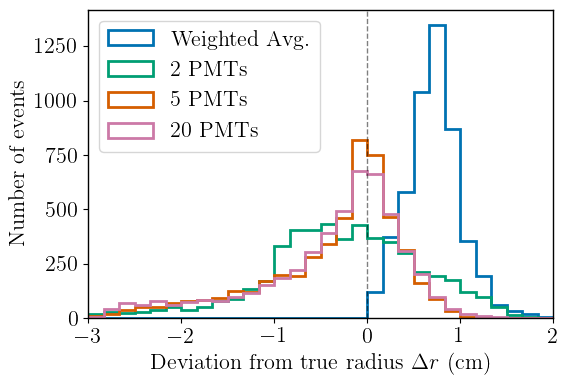

In [66]:
# Do a plot of delta R versus R, comparing the best model with the stupid model and the weighted average estimator

# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)

# Get the radius of the predicted events
r_pred = np.linalg.norm(pred_pos, axis=1)

# Get the radius of the predicted events
stupid_r_pred = np.linalg.norm(stupid_pred_pos, axis=1)

# Get the radius of the predicted events
finest_model_r_pred = np.linalg.norm(finest_pred_pos, axis=1)

# Get the delta r
dr = r_pred - r
stupid_dr = stupid_r_pred - r
finest_dr = finest_model_r_pred - r
wa_dr = np.linalg.norm(wa_pred - pos_test, axis=1)

n_bins = 30

# Plot delta r versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

plt.hist(
    wa_dr,
    bins=n_bins,
    range=(-3,2),
    label="Weighted Avg.",
    histtype="step",
    linewidth=2,

)

plt.hist(
    stupid_dr,
    bins=n_bins,
    range=(-3,2),
    label=f"{_stupid_pmts} PMTs",
    histtype="step",
    linewidth=2,

)


plt.hist(
    dr,
    bins=n_bins,
    range=(-3,2),
    label=f"{_pmts} PMTs",
    histtype="step",
    linewidth=2,

)

plt.hist(
    finest_dr,
    bins=n_bins,
    range=(-3,2),
    label=f"{_finest_pmts} PMTs",
    histtype="step",
    linewidth=2,

)


plt.axvline(0, color="black", linestyle="--", linewidth=1, alpha=0.5)

plt.xlim(-3,2)

plt.xlabel("Deviation from true radius $\Delta r$ (cm)")
plt.ylabel("Number of events")

plt.legend()

save_figure(fig, "dr_per_model_{run_id}")

plt.show()


In [67]:
n_bins = 30

# Get the average distance per each r bin
r_bins = np.linspace(0, radius, n_bins)
r_bin_centers = (r_bins[1:] + r_bins[:-1]) / 2

Figure saved as results_dr_vs_r_per_model_mc0010


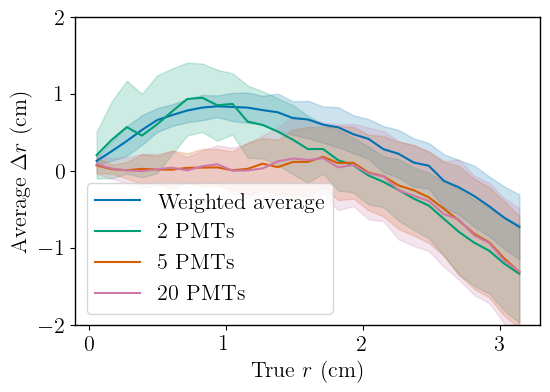

In [68]:
# Now the average distance versus r for the three models

# Get the radius of the events
r = np.linalg.norm(pos_test, axis=1)


# Get the distance between the predicted and true positions
dr = np.linalg.norm(pred_pos, axis=1) - r
stupid_dr = np.linalg.norm(stupid_pred_pos, axis=1) - r
wa_dr = np.linalg.norm(wa_pred, axis=1) - r
finest_dr = np.linalg.norm(finest_pred_pos, axis=1) - r


dr_mean, _, _ = stats.binned_statistic(r, dr, statistic='mean', bins=r_bins)
dr_std, _, _ = stats.binned_statistic(r, dr, statistic='std', bins=r_bins)

stupid_dr_mean, _, _ = stats.binned_statistic(r, stupid_dr, statistic='mean', bins=r_bins)
stupid_dr_std, _, _ = stats.binned_statistic(r, stupid_dr, statistic='std', bins=r_bins)

wa_dr_mean, _, _ = stats.binned_statistic(r, wa_dr, statistic='mean', bins=r_bins)
wa_dr_std, _, _ = stats.binned_statistic(r, wa_dr, statistic='std', bins=r_bins)

finest_dr_mean, _, _ = stats.binned_statistic(r, finest_dr, statistic='mean', bins=r_bins)
finest_dr_std, _, _ = stats.binned_statistic(r, finest_dr, statistic='std', bins=r_bins)


# Plot residuals versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Get first color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    wa_dr_mean,
    markersize=5,
    color=color,
    label="Weighted average",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    wa_dr_mean - wa_dr_std,
    wa_dr_mean + wa_dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     wa_dr_mean,
#     yerr=wa_dr_std,
#     label="Weighted average",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get second color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    stupid_dr_mean,
    markersize=5,
    color=color,
    label=f"{_stupid_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    stupid_dr_mean - stupid_dr_std,
    stupid_dr_mean + stupid_dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     stupid_dr_mean,
#     yerr=stupid_dr_std,
#     label=f"{_stupid_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get third color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

# Plot the mean residuals as a line
plt.plot(
    r_bin_centers,
    dr_mean,
    markersize=5,
    color=color,
    label=f"{_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    dr_mean - dr_std,
    dr_mean + dr_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean residuals
# plt.errorbar(
#     r_bin_centers,
#     dr_mean,
#     yerr=dr_std,
#     label=f"{_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )


color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

# Plot the mean residuals as a line

plt.plot(
    r_bin_centers,
    finest_dr_mean,
    markersize=5,
    color=color,
    label=f"{_finest_pmts} PMTs",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    finest_dr_mean - finest_dr_std,
    finest_dr_mean + finest_dr_std,
    alpha=0.2,
    color=color,
)

plt.xlabel("True $r$ (cm)")
plt.ylabel("Average $\Delta r$ (cm)")

plt.legend()

plt.ylim(-2, 2)

# Add grid
# plt.grid(True)

save_figure(fig, f"dr_vs_r_per_model_{run_id}")

plt.show()

Figure saved as results_dist_vs_r_per_model_mc0010


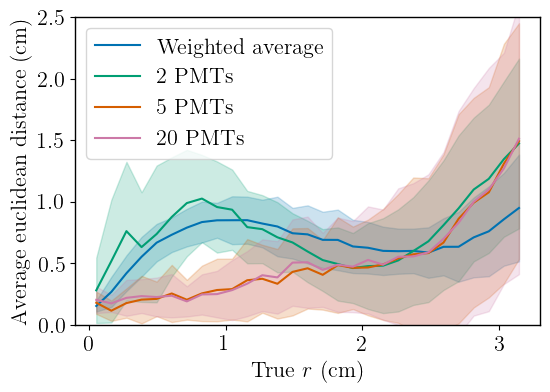

In [69]:
# Plot distance versus r
fig, ax = plt.subplots(1, 1, figsize=(6, 4))


# Get the distance between the predicted and true positions
dist = np.linalg.norm(pred_pos - pos_test, axis=1)

# Get the distance between the predicted and true positions for the stupid model
stupid_model_dist = np.linalg.norm(stupid_pred_pos - pos_test, axis=1)

# Get the distance between the predicted and true positions for the weighted average model
wa_dist = np.linalg.norm(wa_pred - pos_test, axis=1)

# Get the distance between the predicted and true positions for the finest model
finest_model_dist = np.linalg.norm(finest_pred_pos - pos_test, axis=1)

dist_mean, _, _ = stats.binned_statistic(r, dist, statistic='mean', bins=r_bins)
dist_std, _, _ = stats.binned_statistic(r, dist, statistic='std', bins=r_bins)

stupid_model_dist_mean, _, _ = stats.binned_statistic(r, stupid_model_dist, statistic='mean', bins=r_bins)
stupid_model_dist_std, _, _ = stats.binned_statistic(r, stupid_model_dist, statistic='std', bins=r_bins)

wa_dist_mean, _, _ = stats.binned_statistic(r, wa_dist, statistic='mean', bins=r_bins)
wa_dist_std, _, _ = stats.binned_statistic(r, wa_dist, statistic='std', bins=r_bins)

finest_model_dist_mean, _, _ = stats.binned_statistic(r, finest_model_dist, statistic='mean', bins=r_bins)
finest_model_dist_std, _, _ = stats.binned_statistic(r, finest_model_dist, statistic='std', bins=r_bins)


# Get first color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    wa_dist_mean,
    markersize=5,
    color=color,
    label="Weighted average",

)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    wa_dist_mean - wa_dist_std,
    wa_dist_mean + wa_dist_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     wa_dist_mean,
#     yerr=wa_dist_std,
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get second color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    stupid_model_dist_mean,
    markersize=5,
    color=color,
    label=f"{_stupid_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    stupid_model_dist_mean - stupid_model_dist_std,
    stupid_model_dist_mean + stupid_model_dist_std,
    alpha=0.2,
    color=color,

)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     stupid_model_dist_mean,
#     yerr=stupid_model_dist_std,
#     label=f"{_stupid_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

# Get third color of the color cycle
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    dist_mean,
    markersize=5,
    color=color,
    label=f"{_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    dist_mean - dist_std,
    dist_mean + dist_std,
    alpha=0.2,
    color=color,
)

# # Add error bars for the mean distance
# plt.errorbar(
#     r_bin_centers,
#     dist_mean,
#     yerr=dist_std,
#     label=f"{_pmts} PMTs",
#     fmt='o',
#     markersize=5,
#     capsize=3,
#     color=color,
#     alpha=0.5,
# )

color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

# Plot the mean distance as a line
plt.plot(
    r_bin_centers,
    finest_model_dist_mean,
    markersize=5,
    color=color,
    label=f"{_finest_pmts} PMTs",
)

# Add shaded region for the standard deviation
plt.fill_between(
    r_bin_centers,
    finest_model_dist_mean - finest_model_dist_std,
    finest_model_dist_mean + finest_model_dist_std,
    alpha=0.2,
    color=color,
)


plt.xlabel("True $r$ (cm)")
plt.ylabel("Average euclidean distance (cm)")

plt.legend()

plt.ylim(0, 2.5)

# Add grid
# plt.grid(True)

save_figure(fig, f"dist_vs_r_per_model_{run_id}")

plt.show()

## Stupid checks

In [372]:
# check if data is ok

from matplotlib.colors import LogNorm

# import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_one_event(test_heat, predicted_heat, true_heat, true_downsampled_heat, predicted_pos, true_pos, wa_pos):


    # have the y shared between the plots
    fig, ax = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

    ax = ax.ravel()

    values = [
        test_heat,
        predicted_heat,
        true_downsampled_heat,
        true_heat,
    ]

    titles = [
        "Test event",
        "Predicted event",
        "True downsampled",
        "True event",
    ]

    # find min and max of all the values[i]
    vmin = np.min([np.min(v) for v in values])
    vmax = np.max([np.max(v) for v in values])

    for i in range(len(values)):

        im = ax[i].imshow(
            values[i],
            interpolation="nearest",
            origin="lower",
            extent=[-r, r, -r, r],
            # set the same vmax and vmin for all the plots
            # vmin=vmin,
            # vmax=vmax,
        )

        ax[i].set_title(titles[i])

        markersize = 15

        ax[i].plot(
            true_pos[0],
            true_pos[1],
            marker="X",
            markersize=markersize,
            color="red",
            label="true position",
        )

        ax[i].plot(
            predicted_pos[0],
            predicted_pos[1],
            marker="^",
            markersize=markersize,
            color="cyan",
            label="predicted position",
        )

        ax[i].plot(
            wa_pos[0],
            wa_pos[1],
            marker="d",
            markersize=markersize,
            color="m",
            label="Weighted average",
        )

        ax[i].set_xlabel("x (cm)")

        # Add a small text with the total amount of hits
        # so sum all the values in the multi-dimensional array
        ax[i].text(
            -1.5,
            4.2,
            f"Total hits: {np.sum(values[i]):.1f}",
            fontsize=12,
            color="k",
        )

        # add a colorbar right next to the plot without space in between
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    ax[0].set_ylabel("y (cm)")

    # put the legend above the subplots 
    # centralised with respect to the figure
    ax[-1].legend(
        bbox_to_anchor=(-1.5, 1.5), 
        loc='upper center', 
        ncol=3, 
        fontsize=16
    )

    plt.show()


In [373]:
# Get the number of hits for each event
n_hits = np.sum(X_test, axis=(1, 2))
n_hits[:10]

array([  82, 2231, 4336,  673,  175,   57, 8763,  388,   86,   39])

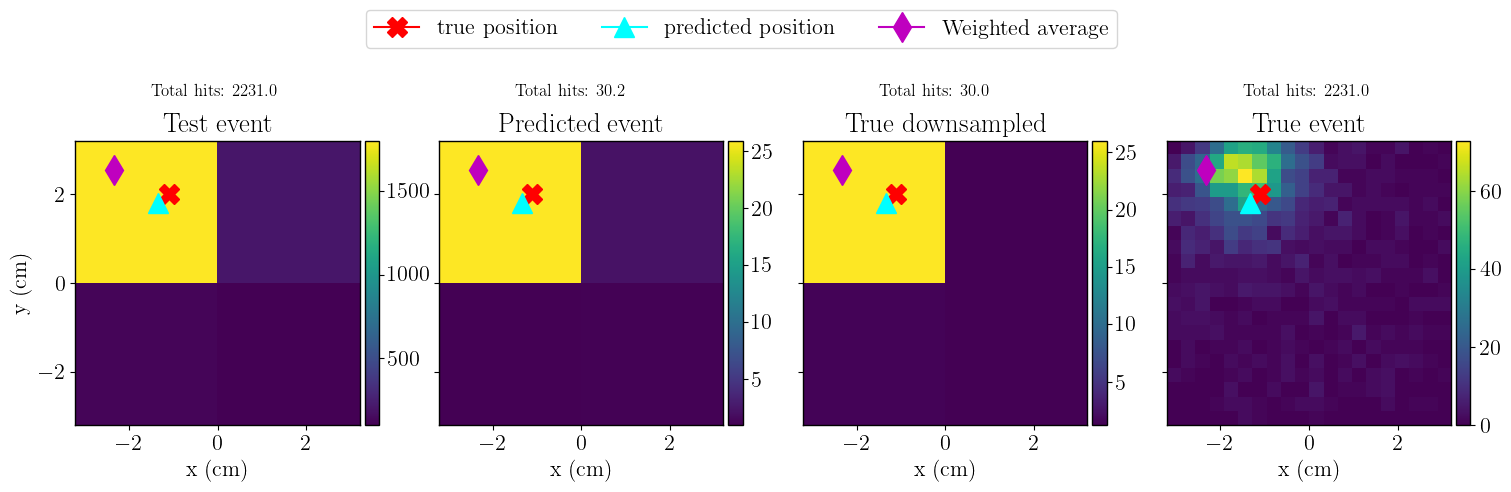

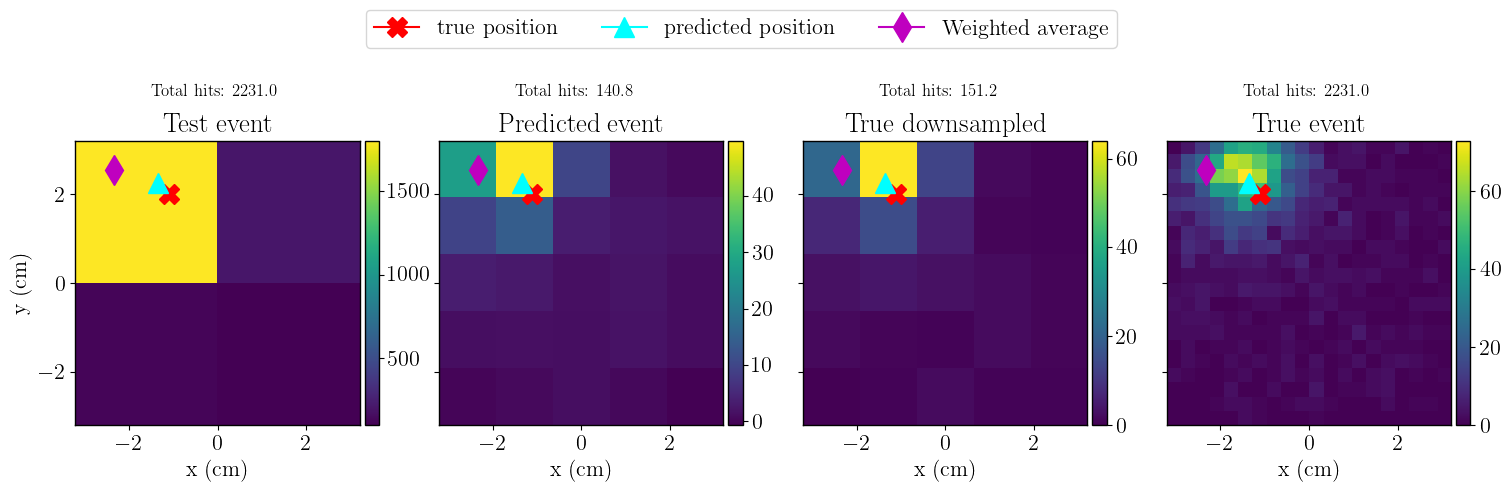

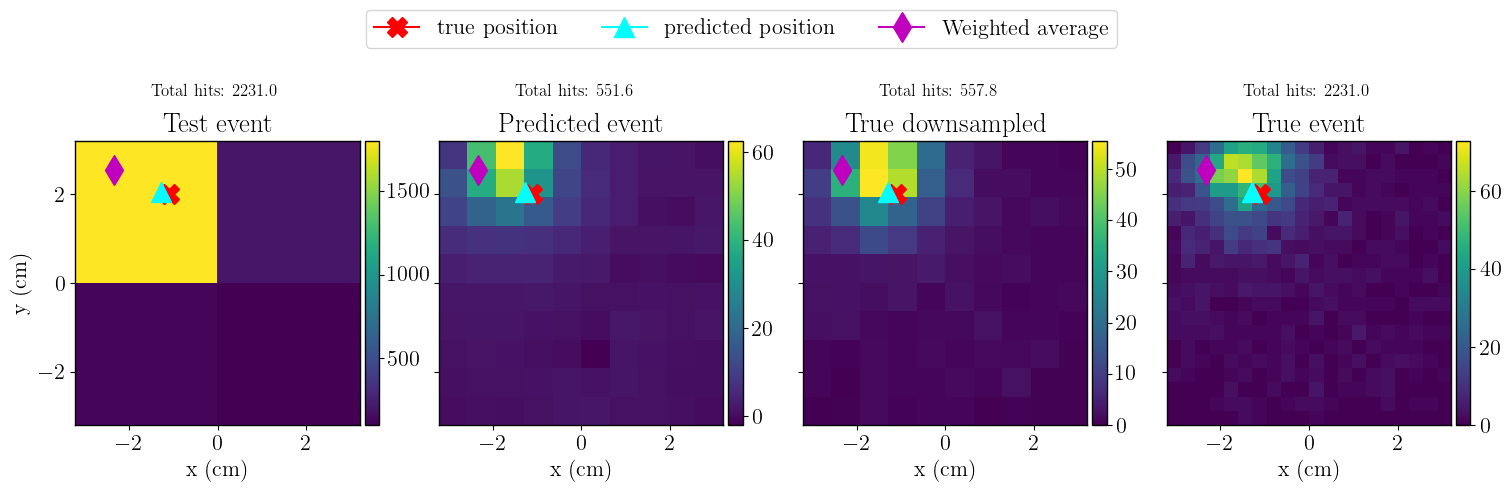

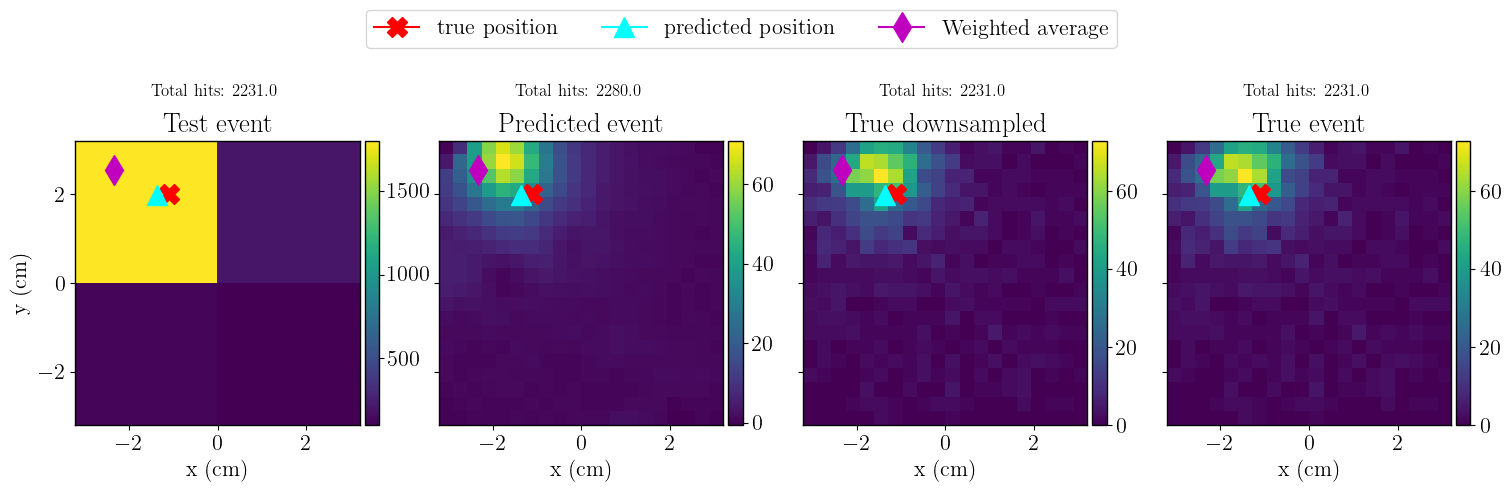

In [377]:
n_pmts = 10
i = 1
r = 3.2

# for n_pmts in range(2,20) one every 3

for n_pmts in [2, 5, 10, 20]:

    model = models[f'model_{n_pmts}x{n_pmts}_{run_id}.pkl']

    test_heat = X_test[i]

    true_pos = pos_test[i]
    true_heat = y_test[i]
    true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([true_heat, ]), n_pmts, n_pmts)[0]

    pred_heat, pred_pos = model.predict(np.array([X_test[i], ]))
    pred_heat = pred_heat[0]
    pred_heat = pred_heat.reshape(n_pmts,n_pmts)
    pred_pos = pred_pos[0]

    wa_pos = weighted_average_estimator(np.array([test_heat, ]), r=r)[0]

    plot_one_event(test_heat, pred_heat, true_heat, true_downsampled_heat, pred_pos, true_pos, wa_pos)

In [406]:
import numpy as np
import scipy.interpolate
import scipy.ndimage

import os
from optosim.settings import MODEL_DIR

def downsample_heatmaps_to_dimensions(heatmaps, new_height, new_width):
    """
    Downsample a list of heatmaps to specified dimensions using averaging.

    Args:
        heatmaps (list of numpy.ndarray): List of high-resolution heatmaps.
        new_height (int): The desired height of the downsampled heatmaps.
        new_width (int): The desired width of the downsampled heatmaps.

    Returns:
        list of numpy.ndarray: List of downsampled heatmaps.
    """
    downsampled_heatmaps = []

    for heatmap in heatmaps:
        # Get the dimensions of the original heatmap
        reshaped_heatmap = congrid(heatmap, (new_height, new_width), method="linear", centre=True, minusone=False)
        downsampled_heatmaps.append(reshaped_heatmap)

    return np.asarray(downsampled_heatmaps)



def congrid(a, newdims, method="linear", centre=False, minusone=False):
    """Arbitrary resampling of source array to new dimension sizes.
    Currently only supports maintaining the same number of dimensions.
    To use 1-D arrays, first promote them to shape (x,1).

    Uses the same parameters and creates the same co-ordinate lookup points
    as IDL's congrid routine, which apparently originally came from a VAX/VMS
    routine of the same name.

    method:
    neighbour - closest value from original data
    nearest and linear - uses n x 1-D interpolations using
                         scipy.interpolate.interp1d
    (see Numerical Recipes for validity of use of n 1-D interpolations)
    spline - uses ndimage.map_coordinates

    centre:
    True - interpolation points are at the centres of the bins
    False - points are at the front edge of the bin

    minusone:
    For example- inarray.shape = (i,j) & new dimensions = (x,y)
    False - inarray is resampled by factors of (i/x) * (j/y)
    True - inarray is resampled by(i-1)/(x-1) * (j-1)/(y-1)
    This prevents extrapolation one element beyond bounds of input array.
    """
    if not a.dtype in [float]:
        a = np.cast[float](a)

    m1 = int(minusone)
    ofs = int(centre) * 0.5
    old = np.array(a.shape)
    ndims = len(a.shape)
    if len(newdims) != ndims:
        print(
            "[congrid] dimensions error. "
            "This routine currently only supports "
            "rebinning to the same number of dimensions."
        )
        return None
    newdims = np.asarray(newdims, dtype=float)
    dimlist = []

    if method == "neighbour":
        for i in range(ndims):
            base = np.indices(newdims)[i]
            dimlist.append((old[i] - m1) / (newdims[i] - m1) * (base + ofs) - ofs)
        cd = np.array(dimlist).round().astype(int)
        newa = a[tuple(cd)]
        return newa

    elif method in ["nearest", "linear"]:
        # calculate new dims
        for i in range(ndims):
            base = np.arange(newdims[i])
            dimlist.append((old[i] - m1) / (newdims[i] - m1) * (base + ofs) - ofs)
        # specify old dims
        olddims = [np.arange(i, dtype=float) for i in list(a.shape)]

        # first interpolation - for ndims = any
        mint = scipy.interpolate.interp1d(olddims[-1], a, kind=method)
        newa = mint(dimlist[-1])

        trorder = [ndims - 1] + list(range(ndims - 1))
        for i in range(ndims - 2, -1, -1):
            newa = newa.transpose(trorder)

            mint = scipy.interpolate.interp1d(olddims[i], newa, kind=method)
            newa = mint(dimlist[i])

        if ndims > 1:
            # need one more transpose to return to original dimensions
            newa = newa.transpose(trorder)

        return newa
    elif method in ["spline"]:
        oslices = [slice(0, j) for j in old]
        oldcoords = np.ogrid[oslices]
        nslices = [slice(0, j) for j in list(newdims)]
        newcoords = np.mgrid[nslices]

        newcoords_dims = list(range(np.rank(newcoords)))
        # make first index last
        newcoords_dims.append(newcoords_dims.pop(0))
        newcoords_tr = newcoords.transpose(newcoords_dims)
        # makes a view that affects newcoords

        newcoords_tr += ofs

        deltas = (np.asarray(old) - m1) / (newdims - m1)
        newcoords_tr *= deltas

        newcoords_tr -= ofs

        newa = scipy.ndimage.map_coordinates(a, newcoords)
        return newa
    else:
        print(
            "Congrid error: Unrecognized interpolation type.\n",
            "Currently only 'neighbour', 'nearest', 'linear',",
            "and 'spline' are supported.",
        )
        return None

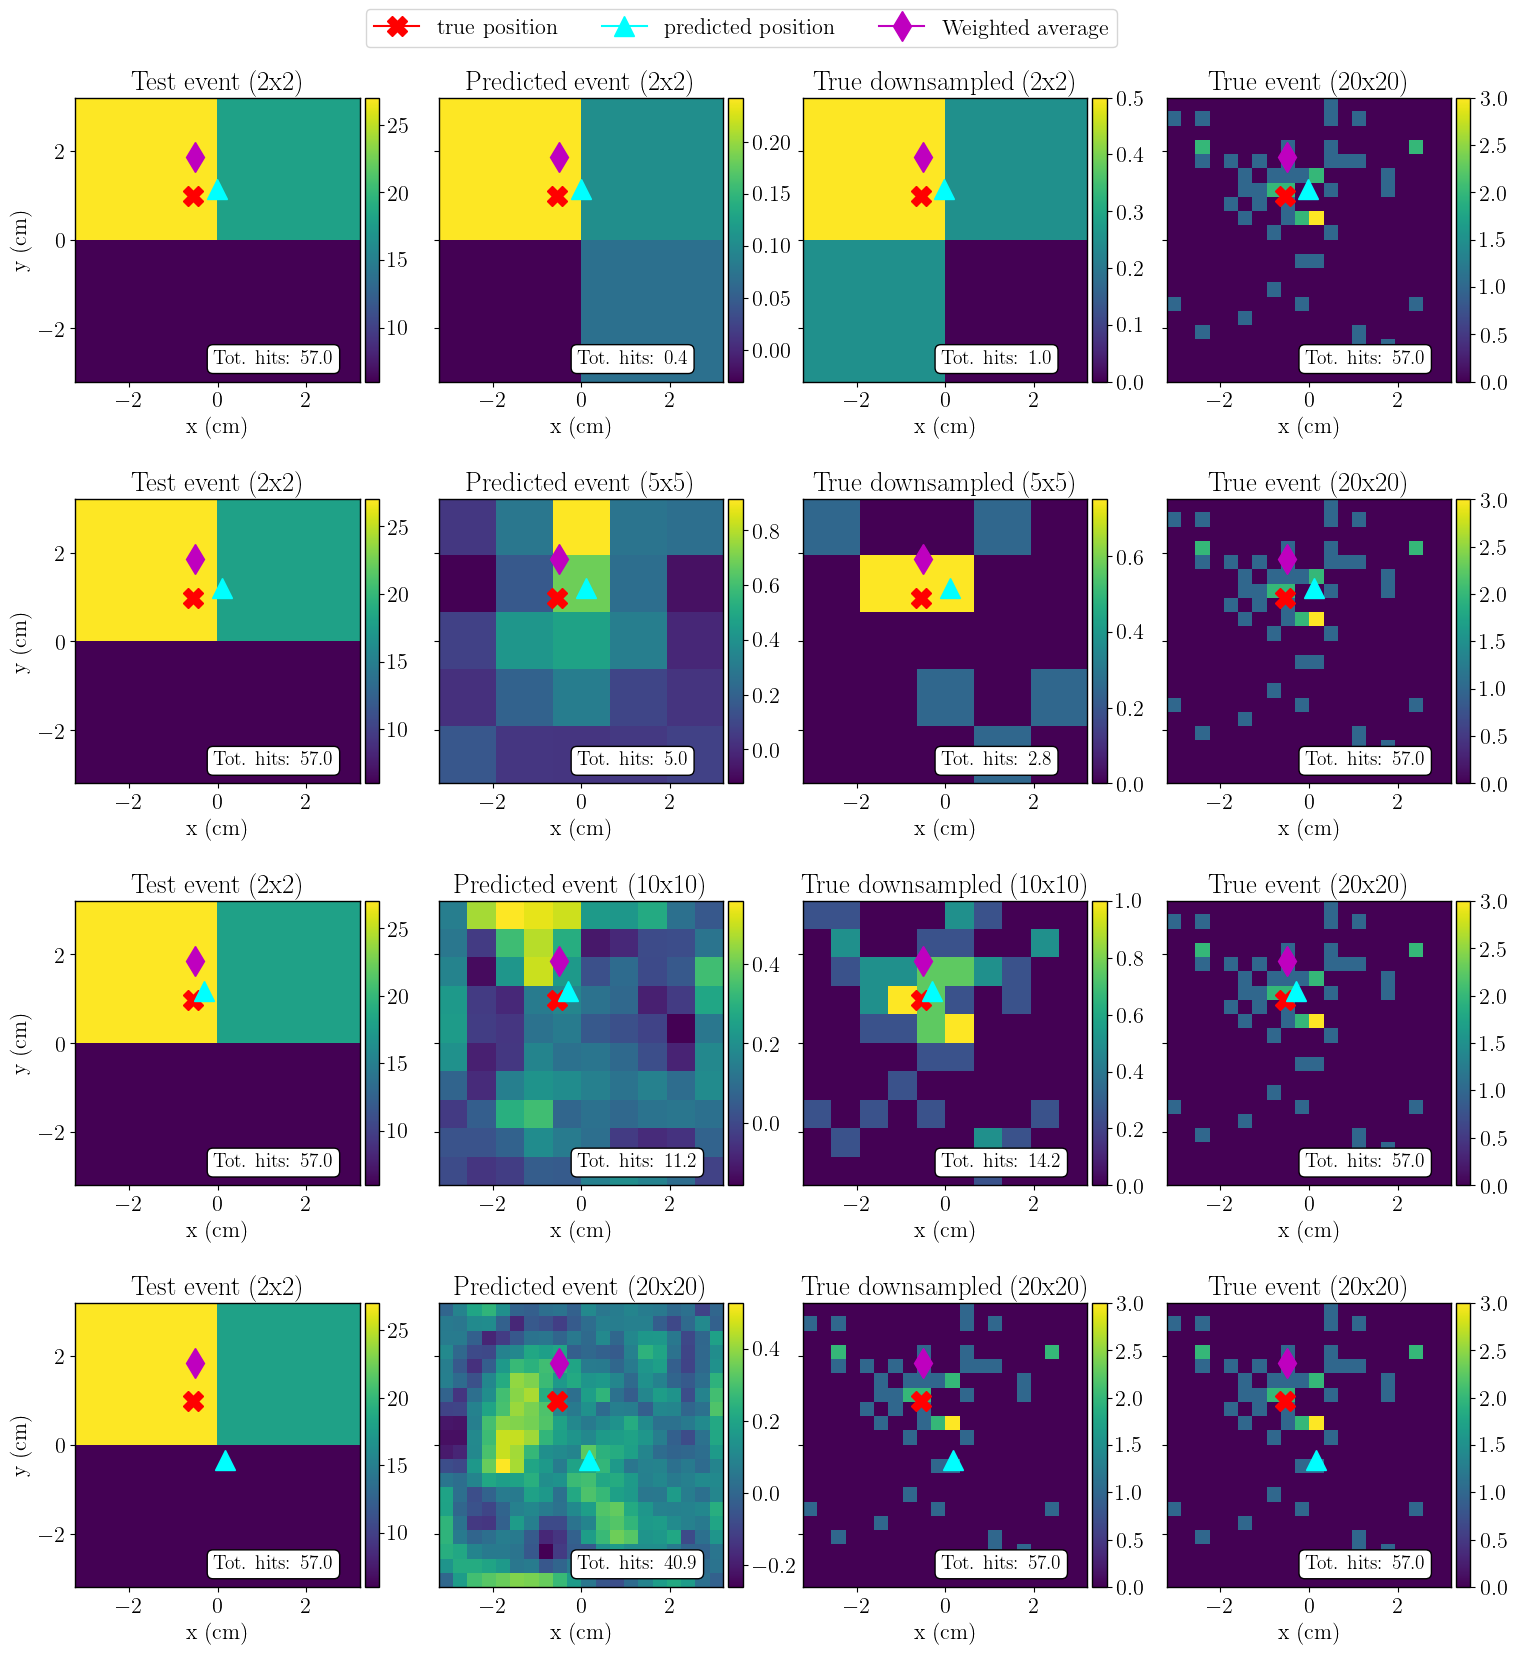

In [492]:
# Now i would like to make a figure in which i do the plot_one_event but for 5 different models. So basically every model a row, and in each row 4 columns, one for each plot_one_event


event_i = 5

r = 3.2
n_pmts_list = [2, 5, 10, 20]

fig, ax = plt.subplots(len(n_pmts_list), 4, figsize=(18, 20), sharey=True)

for j, n_pmts in enumerate(n_pmts_list):

    model = models[f'model_{n_pmts}x{n_pmts}_{run_id}.pkl']

    test_heat = X_test[event_i]

    true_pos = pos_test[event_i]
    true_heat = y_test[event_i]
    true_downsampled_heat = downsample_heatmaps_to_dimensions(np.array([true_heat, ]), n_pmts, n_pmts)[0]

    pred_heat, pred_pos = model.predict(np.array([X_test[event_i], ]))
    pred_heat = pred_heat[0]
    pred_heat = pred_heat.reshape(n_pmts,n_pmts)
    pred_pos = pred_pos[0]

    wa_pos = weighted_average_estimator(np.array([test_heat, ]), r=r)[0]

    values = [
        test_heat,
        pred_heat,
        true_downsampled_heat,
        true_heat,
    ]

    titles = [
        f"Test event (2x2)",
        f"Predicted event ({n_pmts}x{n_pmts})",
        f"True downsampled ({n_pmts}x{n_pmts})",
        f"True event (20x20)",
    ]

    # find min and max of all the values[i]
    vmin = np.min([np.min(v) for v in values])
    vmax = np.max([np.max(v) for v in values])

    for i in range(len(values)):

        im = ax[j, i].imshow(
            values[i],
            interpolation="nearest",
            origin="lower",
            extent=[-r, r, -r, r],
            # set the same vmax and vmin for all the plots
            # vmin=vmin,
            # vmax=vmax,
        )

        ax[j, i].set_title(titles[i])

        markersize = 15

        ax[j, i].plot(
            true_pos[0],
            true_pos[1],
            marker="X",
            markersize=markersize,
            color="red",
            label="true position",
        )

        ax[j, i].plot(
            pred_pos[0],
            pred_pos[1],
            marker="^",
            markersize=markersize,
            color="cyan",
            label="predicted position",
        )

        ax[j, i].plot(
            wa_pos[0],
            wa_pos[1],
            marker="d",
            markersize=markersize,
            color="m",
            label="Weighted average",
        )

        ax[j, i].set_xlabel("x (cm)")

        # Add a small text with the total amount of hits
        # so sum all the values in the multi-dimensional array
        # let's move this text in a small frame in the bottom right of the plot

        ax[j,i].text(
            -0.1,
            -2.8,
            f"Tot. hits: {np.sum(values[i]):.1f}",
            fontsize=14,
            color="k",
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round'
            )
        )

        # add a colorbar right next to the plot without space in between
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    ax[j, 0].set_ylabel("y (cm)")

# put the legend above the subplots 
# centralised with respect to the figure
ax[0, 3].legend(
    bbox_to_anchor=(-1.5, 1.35), 
    loc='upper center', 
    ncol=3, 
    fontsize=16
)

plt.show()

    

In [408]:
true_heat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1,

In [486]:
import numpy as np
from scipy import interpolate

import numpy as np
from scipy.interpolate import RegularGridInterpolator

import numpy as np

import numpy as np
from scipy.interpolate import RegularGridInterpolator

import numpy as np
from scipy.interpolate import RegularGridInterpolator

def rebin(data, N):
    # Ensure the data is a numpy array
    data = np.array(data)
    
    # Create a grid of x and y coordinates for the original data
    x = np.linspace(0, 19, 20)
    y = np.linspace(0, 19, 20)
    
    # Create an interpolating function for the data
    f = RegularGridInterpolator((x, y), data)
    
    # Create a finer grid (e.g., 400x400) using interpolation
    x_fine = np.linspace(0, 19, 400)
    y_fine = np.linspace(0, 19, 400)
    mesh_x, mesh_y = np.meshgrid(x_fine, y_fine)
    pts = np.vstack((mesh_x.ravel(), mesh_y.ravel())).T
    fine_data = f(pts).reshape(400, 400)
    
    # Normalize the fine_data so that its sum is the same as the original data
    fine_data *= np.sum(data) / np.sum(fine_data)
    
    # Calculate the size of the blocks in the finer grid
    block_size = 400 // N
    
    # Create an empty NxN grid
    rebinned_data = np.zeros((N, N))
    
    # For each cell in the new grid
    for i in range(N):
        for j in range(N):
            # Sum the values in the corresponding block in the finer grid
            rebinned_data[j, i] = np.sum(fine_data[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size])
    
    return rebinned_data

import numpy as np
from scipy.interpolate import RegularGridInterpolator

def rebin_single(data, N):
    # This function rebins a single 2D heatmap
    x = np.linspace(0, 19, 20)
    y = np.linspace(0, 19, 20)
    f = RegularGridInterpolator((x, y), data)
    x_fine = np.linspace(0, 19, 400)
    y_fine = np.linspace(0, 19, 400)
    mesh_x, mesh_y = np.meshgrid(x_fine, y_fine)
    pts = np.vstack((mesh_x.ravel(), mesh_y.ravel())).T
    fine_data = f(pts).reshape(400, 400)
    fine_data *= np.sum(data) / np.sum(fine_data)
    block_size = 400 // N
    rebinned_data = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            rebinned_data[j, i] = np.sum(fine_data[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size])
    return rebinned_data

def rebin_heatmaps(data, N):
    # This function handles a 3D array of heatmaps
    num_heatmaps = data.shape[0]
    rebinned_data = np.zeros((num_heatmaps, N, N))
    for i in range(num_heatmaps):
        rebinned_data[i] = rebin_single(data[i], N)
    return rebinned_data


rebin = rebin(true_heat, 4)

In [487]:
# print the sum of values for the original heatmap and the rebinned one
print(np.sum(true_heat))
print(np.sum(rebin))

57
57.00000000000001


In [488]:
len(y_test)

5000

In [489]:
rebinned_heatmaps = rebin_heatmaps(y_test, 10)

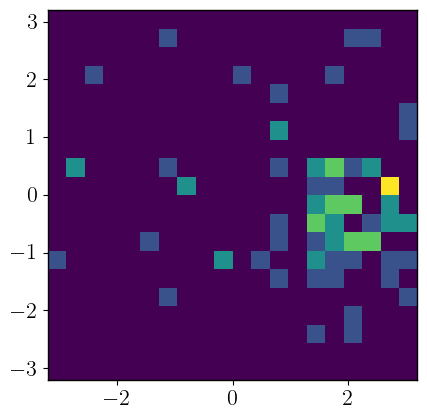

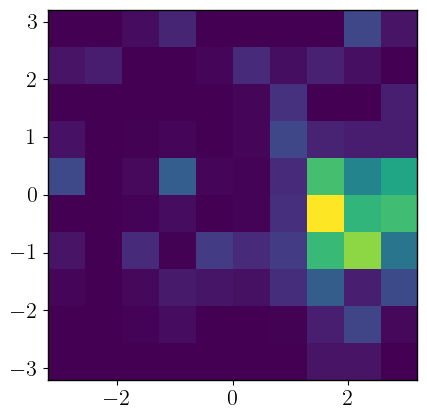

82
81.99999999999999


In [490]:
xxx = 0



plt.imshow(y_test[xxx], interpolation="nearest", origin="lower", extent=[-r, r, -r, r])
plt.show()
plt.imshow(rebinned_heatmaps[xxx], interpolation="nearest", origin="lower", extent=[-r, r, -r, r])
plt.show()

# print the sum of the values for the original heatmap and the rebinned one
print(np.sum(y_test[xxx]))
print(np.sum(rebinned_heatmaps[xxx]))



In [185]:
# I want to plot the distribution of the number of hits per every event in the true data

# Get the number of hits per event
n_hits = np.sum(y_test, axis=(1,2))


In [119]:
n_hits

array([  82, 2231, 4336, ..., 1276,   60,  233])

(array([  1.,   3.,   6.,   6.,  14.,  36.,  22.,  37.,  84., 101., 115.,
        110., 129., 121., 120., 127., 124., 109., 142., 121., 130., 122.,
        125., 109., 118., 140., 124., 149., 130., 118., 119., 134., 148.,
        128., 104., 129., 107., 137., 121., 124., 132., 110., 119., 124.,
        125.,  90.,  97.,  76.,  57.,  26.]),
 array([0.69897   , 0.7739347 , 0.84889939, 0.92386408, 0.99882877,
        1.07379346, 1.14875815, 1.22372284, 1.29868753, 1.37365222,
        1.44861692, 1.52358161, 1.5985463 , 1.67351099, 1.74847568,
        1.82344037, 1.89840506, 1.97336975, 2.04833444, 2.12329914,
        2.19826383, 2.27322852, 2.34819321, 2.4231579 , 2.49812259,
        2.57308728, 2.64805197, 2.72301666, 2.79798136, 2.87294605,
        2.94791074, 3.02287543, 3.09784012, 3.17280481, 3.2477695 ,
        3.32273419, 3.39769888, 3.47266358, 3.54762827, 3.62259296,
        3.69755765, 3.77252234, 3.84748703, 3.92245172, 3.99741641,
        4.0723811 , 4.1473458 , 4.22231049, 4.

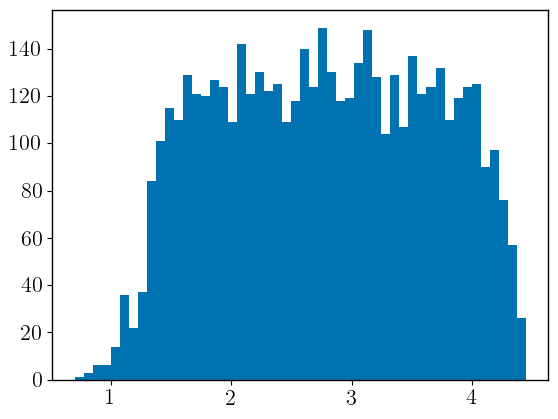

In [121]:
plt.hist(np.log10(n_hits), bins=50)

In [122]:
# how many hits with < 100 ?

np.sum(n_hits < 100)

1189

In [123]:
len(n_hits)

5000